# Cell 1: Import Libraries

In [1]:
# Cell 1: Import Libraries

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from deap import base, creator, tools, algorithms

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Enable inline plotting
%matplotlib inline


In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


# Cell 2: Data Loading and Preprocessing

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
                         (0.2023, 0.1994, 0.2010))  # CIFAR-10 std
])

# Load CIFAR-10 dataset
full_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

# Reduce dataset size to simulate limited data
small_dataset_size = 5000  # Use only 5,000 samples
indices = list(range(len(full_dataset)))
random.shuffle(indices)
small_indices = indices[:small_dataset_size]
small_dataset = torch.utils.data.Subset(full_dataset, small_indices)

# Split small_dataset into train and validation sets
from torch.utils.data import random_split

train_size = int(0.8 * len(small_dataset))
val_size = len(small_dataset) - train_size
train_subset, val_subset = random_split(small_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


# Cell 3: Visualize Sample Data

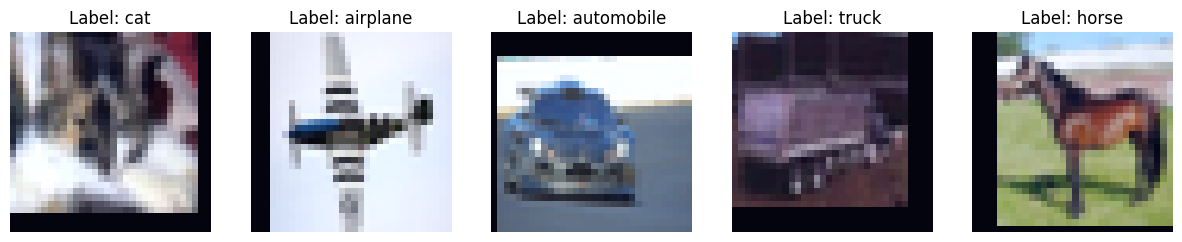

In [4]:


def show_images(dataset, indices):
    classes = dataset.classes
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 4))
    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.2 + 0.5, 0, 1)  # Approximate denormalization
        ax.imshow(img)
        ax.set_title(f'Label: {classes[label]}')
        ax.axis('off')
    plt.show()

# Display first 5 images in the small dataset
sample_indices = small_indices[:5]
show_images(full_dataset, sample_indices)


# Cell 4: Define the Search Space and Evolutionary Algorithm Setup

In [5]:


# Possible values for network architecture
NUM_LAYERS = [1, 2, 3]
NUM_FILTERS = [16, 32, 64, 128]
KERNEL_SIZES = [3, 5]
ACTIVATION_FUNCTIONS = [nn.ReLU, nn.Tanh]
LEARNING_RATES = [0.01, 0.001, 0.0001]

# Define individual and fitness classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

# Function to create an individual
def create_individual():
    num_layers = random.choice(NUM_LAYERS)
    filters = [random.choice(NUM_FILTERS) for _ in range(num_layers)]
    kernel_sizes = [random.choice(KERNEL_SIZES) for _ in range(num_layers)]
    activation = random.choice(ACTIVATION_FUNCTIONS)
    learning_rate = random.choice(LEARNING_RATES)
    return creator.Individual([filters, kernel_sizes, activation, learning_rate])

# Initialize the toolbox
toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Cell 5: Define the Evaluation Function

In [6]:


def evaluate_individual(individual):
    filters, kernel_sizes, activation_fn, learning_rate = individual
    num_classes = 10  # CIFAR-10 has 10 classes

    # Define the neural network architecture
    class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            layers = []
            input_channels = 3  # CIFAR-10 images have 3 channels (RGB)
            for out_channels, kernel_size in zip(filters, kernel_sizes):
                layers.append(nn.Conv2d(input_channels, out_channels, kernel_size=kernel_size, padding=1))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(activation_fn())
                layers.append(nn.MaxPool2d(2))
                input_channels = out_channels
            self.features = nn.Sequential(*layers)
            
            # Dynamically compute the flattened size
            with torch.no_grad():
                sample_input = torch.randn(1, 3, 32, 32)
                sample_output = self.features(sample_input)
                flattened_size = sample_output.numel()
            
            self.classifier = nn.Linear(flattened_size, num_classes)
        
        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x


    # Initialize the network
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 1  # Keep epochs low for quick evaluation
    model.train()
    try:
        for epoch in range(epochs):
            for data, target in train_loader:
                #print(f"Data shape: {data.shape}, Target shape: {target.shape}")
                break  # Only need to check one batch
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        # Evaluate accuracy on training data
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data, target in train_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = correct / total
    except Exception as e:
        # If the model fails to train, assign a low fitness score
        print(f"Exception occurred during training: {e}")
        accuracy = 0.0
    return (accuracy, )


# Cell 6: Define Genetic Operators

In [7]:


def mutate_individual(individual):
    # Mutate filters and kernel sizes
    if random.random() < 0.5:
        num_layers = random.choice(NUM_LAYERS)
        individual[0] = [random.choice(NUM_FILTERS) for _ in range(num_layers)]
        individual[1] = [random.choice(KERNEL_SIZES) for _ in range(num_layers)]
    # Mutate activation function
    if random.random() < 0.5:
        individual[2] = random.choice(ACTIVATION_FUNCTIONS)
    # Mutate learning rate
    if random.random() < 0.5:
        individual[3] = random.choice(LEARNING_RATES)
    return individual,

def crossover_individuals(ind1, ind2):
    # Swap filters and kernel sizes
    if random.random() < 0.5:
        ind1[0], ind2[0] = ind2[0], ind1[0]
        ind1[1], ind2[1] = ind2[1], ind1[1]
    # Swap activation function
    if random.random() < 0.5:
        ind1[2], ind2[2] = ind2[2], ind1[2]
    # Swap learning rate
    if random.random() < 0.5:
        ind1[3], ind2[3] = ind2[3], ind1[3]
    return ind1, ind2

# Register genetic operators
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)


# Cell 7: Run the Evolutionary Algorithm


In [8]:

def run_evolution():
    population_size = 10  # Start with a small population
    num_generations = 5   # Use fewer generations for quick testing
    population = toolbox.population(n=population_size)

    # Statistics to keep track of progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # Evolutionary algorithm parameters
    cxpb = 0.5  # Crossover probability
    mutpb = 0.2  # Mutation probability

    # Run the evolutionary algorithm
    population, logbook = algorithms.eaSimple(population, toolbox,
                                              cxpb=cxpb, mutpb=mutpb,
                                              ngen=num_generations,
                                              stats=stats,
                                              verbose=True)
    return population, logbook

population, logbook = run_evolution()


KeyboardInterrupt: 

# Cell 8: Analyze Results

Best Individual:
Filters per Layer: [128, 32, 128]
Kernel Sizes: [3, 3, 3]
Activation Function: Tanh
Learning Rate: 0.0001
Fitness (Accuracy): 0.1388


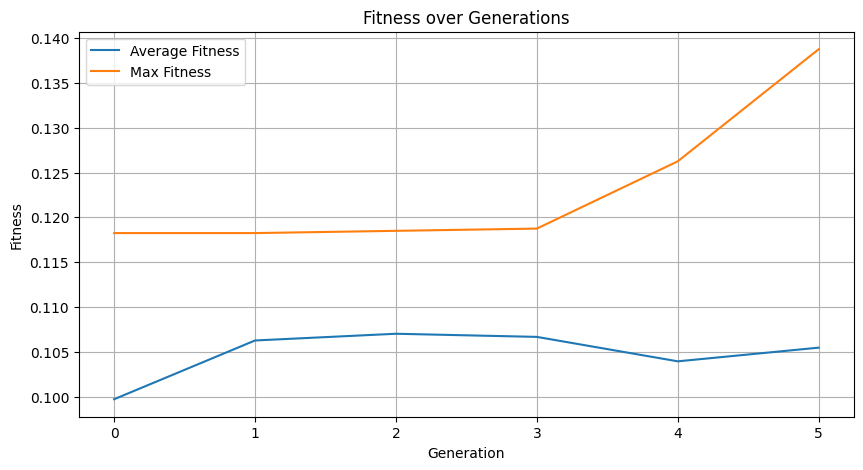

In [ ]:


# Find the best individual
top_individual = tools.selBest(population, k=1)[0]
filters, kernel_sizes, activation_fn, learning_rate = top_individual

print("Best Individual:")
print(f"Filters per Layer: {filters}")
print(f"Kernel Sizes: {kernel_sizes}")
print(f"Activation Function: {activation_fn.__name__}")
print(f"Learning Rate: {learning_rate}")
print(f"Fitness (Accuracy): {top_individual.fitness.values[0]:.4f}")

# Plot the evolution of fitness over generations
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
max_fitness = logbook.select("max")

plt.figure(figsize=(10, 5))
plt.plot(gen, avg_fitness, label='Average Fitness')
plt.plot(gen, max_fitness, label='Max Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.legend()
plt.grid(True)
plt.show()


# Cell 9: Visualize the Best Model's Performance

In [ ]:


# Re-train the best model to see its performance
best_filters = filters
best_kernel_sizes = kernel_sizes
best_activation_fn = activation_fn
best_learning_rate = learning_rate

class BestConvNet(nn.Module):
    def __init__(self):
        super(BestConvNet, self).__init__()
        layers = []
        input_channels = 3
        for out_channels, kernel_size in zip(best_filters, best_kernel_sizes):
            layers.append(nn.Conv2d(input_channels, out_channels, kernel_size=kernel_size, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(best_activation_fn())
            layers.append(nn.MaxPool2d(2))
            input_channels = out_channels
        layers.append(nn.Flatten())
        self.features = nn.Sequential(*layers)
        
        # Dynamically compute the flattened size
        with torch.no_grad():
            sample_input = torch.randn(1, 3, 32, 32)
            sample_output = self.features(sample_input)
            flattened_size = sample_output.view(-1).shape[0]
        
        self.classifier = nn.Linear(flattened_size, 10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Initialize the network
best_model = BestConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)

# Training loop
epochs = 5  # Train for more epochs
best_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = best_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# Evaluate on training data
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for data, target in train_loader:
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
accuracy = correct / total
print(f'Training Accuracy: {accuracy:.4f}')


Epoch 1/5, Loss: 2.0550
Epoch 2/5, Loss: 1.8300
Epoch 3/5, Loss: 1.7456
Epoch 4/5, Loss: 1.7017
Epoch 5/5, Loss: 1.6412
Training Accuracy: 0.4422


# Cell 10: Test on Validation Data (Optional)

In [ ]:


# Load test dataset
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate on test data
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Files already downloaded and verified
Test Accuracy: 0.4155
